<a href="https://colab.research.google.com/github/Tony607/mmdetection_object_detection_demo/blob/master/mmdetection_train_custom_coco_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train an object detection model with mmdetection](https://www.dlology.com/blog/how-to-train-an-object-detection-model-with-mmdetection/) | DLology blog

In [0]:
# You can add more model configs like below.
MODELS_CONFIG = {
    'faster_rcnn_r50_fpn_1x': {
        'config_file': 'configs/faster_rcnn_r50_fpn_1x.py'
    },
    'cascade_rcnn_r50_fpn_1x': {
        'config_file': 'configs/cascade_rcnn_r50_fpn_1x.py',
    },
    'retinanet_r50_fpn_1x': {
        'config_file': 'configs/retinanet_r50_fpn_1x.py',
    }
}

## Your settings

In [0]:
# TODO: change URL to your fork of my repository if necessary.
git_repo_url = 'https://github.com/Tony607/mmdetection_object_detection_demo'

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_r50_fpn_1x'  # 'cascade_rcnn_r50_fpn_1x'

# Total training epochs.
total_epochs = 8

# Name of the config file.
config_file = MODELS_CONFIG[selected_model]['config_file']

## Install Open MMLab Detection Toolbox
Restart the runtime if you have issue importing `mmdet` later on.


In [0]:
import os
from os.path import exists, join, basename, splitext

%cd /content
project_name = os.path.abspath(splitext(basename(git_repo_url))[0])
mmdetection_dir = os.path.join(project_name, "mmdetection")
if not exists(project_name):
    # clone "depth 1" will only get the latest copy of the relevant files.
    !git clone -q --recurse-submodules --depth 1 $git_repo_url
    print("Update mmdetection repo")
    !cd {mmdetection_dir} && git checkout master && git pull
    # dependencies
    !pip install -q mmcv terminaltables
    # build
    !cd {mmdetection_dir} && python setup.py install
    !pip install -r {os.path.join(mmdetection_dir, "requirements.txt")}


import sys
sys.path.append(mmdetection_dir)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

/content
     |████████████████████████████████| 51kB 2.0MB/s 
Building roi align op...
running build_ext
building 'roi_align_cuda' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/src
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/torch/include -I/usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.6/dist-packages/torch/include/TH -I/usr/local/lib/python3.6/dist-packages/torch/include/THC -I/usr/local/cuda/include -I/usr/include/python3.6m -c src/roi_align_cuda.cpp -o build/temp.linux-x86_64-3.6/src/roi_align_cuda.o -DTORCH_API_INCLUDE_EXTENSION_H -DTORCH_EXTENSION_NAME=roi_align_cuda -D_GLIBCXX_USE_CXX11_ABI=0 -std=c++11
/usr/local/cuda/bin/nvcc -I/usr/local/lib/python3.6/dist-packages/torch/include -I/usr/local/lib/python3.6/dist-packag

## Stash the repo if you want to re-modify `voc.py` and config file.

In [0]:
# !cd {mmdetection_dir} && git config --global user.email "zcw607@gmail.com" && git config --global user.name "Tony607" && git stash

### parse data classes

In [0]:
%cd {project_name}

import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
anno_path = os.path.join(project_name, "data/VOC2007/Annotations")
classes_names = []
xml_list = []
for xml_file in glob.glob(anno_path + "/*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall("object"):
        classes_names.append(member[0].text)
classes_names = list(set(classes_names))
classes_names.sort()
classes_names

/content/mmdetection_object_detection_demo


['date', 'fig', 'hazelnut']

## voc2coco
[Previously](https://www.dlology.com/blog/how-to-train-an-object-detection-model-with-mmdetection/), we have trained a mmdetection model with custom annotated dataset in Pascal VOC data format. We will reuse the annotation by converting them into voco data format. Read more about it here
[How to create custom COCO data set for object detection](https://www.dlology.com/blog/how-to-create-custom-coco-data-set-for-object-detection/)

In [0]:
import sys
import os
import json
import xml.etree.ElementTree as ET
import glob

START_BOUNDING_BOX_ID = 1
PRE_DEFINE_CATEGORIES = None
# If necessary, pre-define category and its id
#  PRE_DEFINE_CATEGORIES = {"aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4,
#  "bottle":5, "bus": 6, "car": 7, "cat": 8, "chair": 9,
#  "cow": 10, "diningtable": 11, "dog": 12, "horse": 13,
#  "motorbike": 14, "person": 15, "pottedplant": 16,
#  "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20}


def get(root, name):
    vars = root.findall(name)
    return vars


def get_and_check(root, name, length):
    vars = root.findall(name)
    if len(vars) == 0:
        raise ValueError("Can not find %s in %s." % (name, root.tag))
    if length > 0 and len(vars) != length:
        raise ValueError(
            "The size of %s is supposed to be %d, but is %d."
            % (name, length, len(vars))
        )
    if length == 1:
        vars = vars[0]
    return vars


def get_filename_as_int(filename):
    try:
        filename = filename.replace("\\", "/")
        filename = os.path.splitext(os.path.basename(filename))[0]
        return int(filename)
    except:
        raise ValueError("Filename %s is supposed to be an integer." % (filename))


def get_categories(xml_files):
    """Generate category name to id mapping from a list of xml files.
    
    Arguments:
        xml_files {list} -- A list of xml file paths.
    
    Returns:
        dict -- category name to id mapping.
    """
    classes_names = []
    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall("object"):
            classes_names.append(member[0].text)
    classes_names = list(set(classes_names))
    classes_names.sort()
    return {name: i for i, name in enumerate(classes_names)}


def convert(xml_files, json_file):
    json_dict = {"images": [], "type": "instances", "annotations": [], "categories": []}
    if PRE_DEFINE_CATEGORIES is not None:
        categories = PRE_DEFINE_CATEGORIES
    else:
        categories = get_categories(xml_files)
    bnd_id = START_BOUNDING_BOX_ID
    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        path = get(root, "path")
        if len(path) == 1:
            filename = os.path.basename(path[0].text)
        elif len(path) == 0:
            filename = get_and_check(root, "filename", 1).text
        else:
            raise ValueError("%d paths found in %s" % (len(path), xml_file))
        ## The filename must be a number
        image_id = get_filename_as_int(filename)
        size = get_and_check(root, "size", 1)
        width = int(get_and_check(size, "width", 1).text)
        height = int(get_and_check(size, "height", 1).text)
        image = {
            "file_name": os.path.basename(filename.replace("\\","/")),
            "height": height,
            "width": width,
            "id": image_id,
        }
        json_dict["images"].append(image)
        ## Currently we do not support segmentation.
        #  segmented = get_and_check(root, 'segmented', 1).text
        #  assert segmented == '0'
        for obj in get(root, "object"):
            category = get_and_check(obj, "name", 1).text
            if category not in categories:
                new_id = len(categories)
                categories[category] = new_id
            category_id = categories[category]
            bndbox = get_and_check(obj, "bndbox", 1)
            xmin = int(get_and_check(bndbox, "xmin", 1).text) - 1
            ymin = int(get_and_check(bndbox, "ymin", 1).text) - 1
            xmax = int(get_and_check(bndbox, "xmax", 1).text)
            ymax = int(get_and_check(bndbox, "ymax", 1).text)
            assert xmax > xmin
            assert ymax > ymin
            o_width = abs(xmax - xmin)
            o_height = abs(ymax - ymin)
            ann = {
                "area": o_width * o_height,
                "iscrowd": 0,
                "image_id": image_id,
                "bbox": [xmin, ymin, o_width, o_height],
                "category_id": category_id,
                "id": bnd_id,
                "ignore": 0,
                "segmentation": [],
            }
            json_dict["annotations"].append(ann)
            bnd_id = bnd_id + 1

    for cate, cid in categories.items():
        cat = {"supercategory": "none", "id": cid, "name": cate}
        json_dict["categories"].append(cat)

    os.makedirs(os.path.dirname(json_file), exist_ok=True)
    json_fp = open(json_file, "w")
    json_str = json.dumps(json_dict)
    json_fp.write(json_str)
    json_fp.close()

In [0]:
xml_dir = "data/VOC2007/Annotations/"
xml_files = glob.glob(os.path.join(xml_dir, "*.xml"))

trainval_split_file = "data/VOC2007/ImageSets/Main/trainval.txt"
test_split_file = "data/VOC2007/ImageSets/Main/test.txt"

def get_split_xml_files(xml_files, split_file):
    with open(split_file) as f:
        file_names = [line.strip() for line in f.readlines()]
    return [xml_file for xml_file in xml_files if os.path.splitext(os.path.basename(xml_file))[0] in file_names]

trainval_xml_files = get_split_xml_files(xml_files, trainval_split_file)
test_xml_files = get_split_xml_files(xml_files, test_split_file)

convert(trainval_xml_files, "data/coco/trainval.json")
convert(test_xml_files, "data/coco/test.json")

## Modify object detectio model config file to take our custom coco dataset.

In [0]:
import os
config_fname = os.path.join(project_name, 'mmdetection', config_file)
assert os.path.isfile(config_fname), '`{}` not exist'.format(config_fname)
config_fname

'/content/mmdetection_object_detection_demo/mmdetection/configs/faster_rcnn_r50_fpn_1x.py'

In [0]:
import re
fname = config_fname
with open(fname) as f:
    s = f.read()
    work_dir = re.findall(r"work_dir = \'(.*?)\'", s)[0]
    # Update `num_classes` including `background` class.
    s = re.sub('num_classes=.*?,',
               'num_classes={},'.format(len(classes_names) + 1), s)
    s = re.sub('ann_file=.*?\],',
               "ann_file=data_root + 'VOC2007/ImageSets/Main/trainval.txt',", s, flags=re.S)
    s = re.sub('total_epochs = \d+',
               'total_epochs = {} #'.format(total_epochs), s)
    if "CocoDataset" in s:
        s = re.sub("data_root = 'data/coco/'",
                   "data_root = 'data/'", s)
        s = re.sub("annotations/instances_train2017.json",
                   "coco/trainval.json", s)
        s = re.sub("annotations/instances_val2017.json",
                   "coco/test.json", s)
        s = re.sub("annotations/instances_val2017.json",
                   "coco/test.json", s)
        s = re.sub("train2017", "VOC2007/JPEGImages", s)
        s = re.sub("val2017", "VOC2007/JPEGImages", s)
    else:
        s = re.sub('img_prefix=.*?\],',
                   "img_prefix=data_root + 'VOC2007/JPEGImages',".format(total_epochs), s)
with open(fname, 'w') as f:
    f.write(s)
!cat {config_fname}

# model settings
model = dict(
    type='FasterRCNN',
    pretrained='modelzoo://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_scales=[8],
        anchor_ratios=[0.5, 1.0, 2.0],
        anchor_strides=[4, 8, 16, 32, 64],
        target_means=[.0, .0, .0, .0],
        target_stds=[1.0, 1.0, 1.0, 1.0],
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0)),
    bbox_roi_extractor=dict(
        type='SingleRoIExtractor',
        roi_layer=dict(type='RoIAlign', out_size=7, sample_num=2),
        out_channels=256

## Train the model

In [0]:
%cd {project_name}
!python mmdetection/tools/train.py {config_fname}

/content/mmdetection_object_detection_demo
2019-07-17 03:34:34,393 - INFO - Distributed training: False
2019-07-17 03:34:34,887 - INFO - load model from: modelzoo://resnet50
2019-07-17 03:34:35,229 - WARNING - unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer3.3.bn1.num_batches_tracked, bn1.num_batches_tracked, layer3.0.bn2.num_batches_tracked, layer1.2.bn1.num_batches_tracked, layer3.4.bn1.num_batches_tracked, layer3.4.bn3.num_batches_tracked, layer2.1.bn2.num_batches_tracked, layer2.0.bn1.num_batches_tracked, layer2.2.bn3.num_batches_tracked, layer2.3.bn1.num_batches_tracked, layer3.3.bn3.num_batches_tracked, layer2.1.bn1.num_batches_tracked, layer3.1.bn1.num_batches_tracked, layer4.1.bn3.num_batches_tracked, layer2.1.bn3.num_batches_tracked, layer4.2.bn2.num_batches_tracked, layer1.0.bn2.num_batches_tracked, layer1.1.bn1.num_batches_tracked, layer3.1.bn2.num_batches_tracked, layer3.1.bn3.num_batches_tracked, layer2.2.bn1.num_batches_tr

### Verify the checkpoint file exists.

In [0]:
%cd {project_name}
checkpoint_file = os.path.join(work_dir, "latest.pth")
assert os.path.isfile(
    checkpoint_file), '`{}` not exist'.format(checkpoint_file)
checkpoint_file = os.path.abspath(checkpoint_file)
checkpoint_file

/content/mmdetection_object_detection_demo


'/content/mmdetection_object_detection_demo/work_dirs/faster_rcnn_r50_fpn_1x/latest.pth'

## Test predict

Turn down the `score_thr` if you think the model is missing any bbox.
Turn up the `score_thr` if you see too much overlapping bboxes with low scores.

In [0]:
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

import mmcv
from mmcv.runner import load_checkpoint
import mmcv.visualization.image as mmcv_image
# fix for colab


def imshow(img, win_name='', wait_time=0): plt.figure(
    figsize=(50, 50)); plt.imshow(img)


mmcv_image.imshow = imshow
from mmdet.models import build_detector
from mmdet.apis import inference_detector, show_result, init_detector

In [0]:
score_thr = 0.7

# build the model from a config file and a checkpoint file
model = init_detector(config_fname, checkpoint_file)

# test a single image and show the results
img = 'data/VOC2007/JPEGImages/15.jpg'

result = inference_detector(model, img)
show_result(img, result, classes_names,
            score_thr=score_thr, out_file="result.jpg")

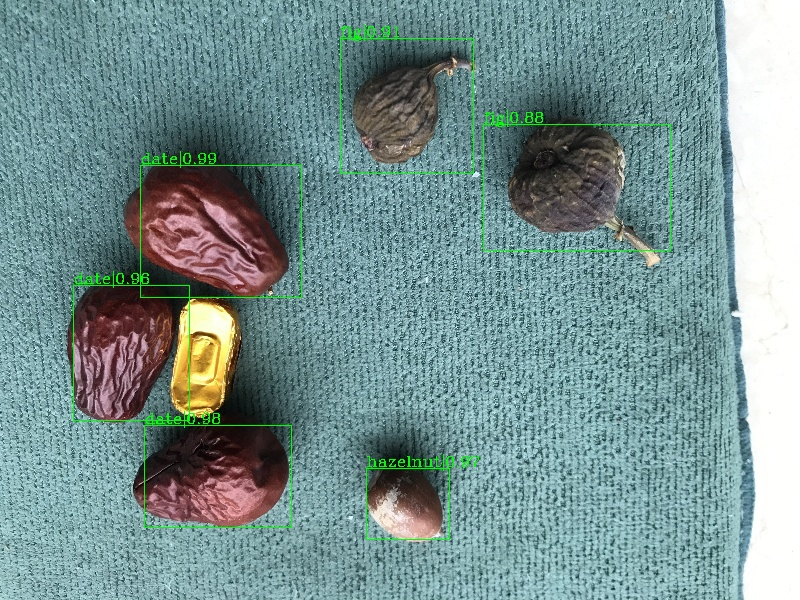

In [0]:
from IPython.display import Image
Image(filename='result.jpg')

## Download the config file

In [0]:
from google.colab import files

files.download(config_fname)

## Download checkpoint file.

### Option1 : upload the checkpoint file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(checkpoint_file)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(checkpoint_file)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

### Option2 :  Download the checkpoint file directly to your local file system
This method may not be stable when downloading large files like the model checkpoint file. Try **option 1** instead if not working.

In [0]:
files.download(checkpoint_file)